In [10]:
from __future__ import division
import pandas as pd
import numpy as np
import datetime
import time
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']


import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline
# For time stamps
from datetime import datetime

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

In [11]:
# Set up End and Start times for data grab
tech_list = ['2382.HK','1299.HK','0388.HK']
# tech_list = ['0002.HK', '0003.HK', '0012.HK', '0017.HK','1398.HK','3988.HK','0669.HK','2382.HK','1299.HK','0388.HK']
# company_name = ['中電', '煤氣', '恒基', '新世界','工商','中國銀行','創科實業','友邦','港交所']
dfs = {}  # 使用字典存储每个股票的数据

for stock in tech_list:
    data = yf.download(stock, "2011-01-01", "2018-12-31")
    dfs[stock] = data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [12]:
data = dfs[tech_list[2]].filter(['Close'])

data['chg'] = data.pct_change()
data['nextWeekChg'] = 1/(1+data['Close'].pct_change(-5))
dataset = data.dropna()
x_dataset =dataset.filter(['chg']).values

y_dataset =dataset.filter(['nextWeekChg']).values
training_data_len = int(np.ceil( len(dataset) * .60 ))

scaler = MinMaxScaler(feature_range=(0,1))
x_scaled_data = scaler.fit_transform(x_dataset)
y_scaled_data = scaler.fit_transform(y_dataset)
x_scaled_data.shape , y_scaled_data.shape

((1964, 1), (1964, 1))

In [13]:
data

,Close,chg,nextWeekChg
Date,,,
2011-01-03,179.800003,NaN,1.013348
2011-01-04,185.600006,0.032258,0.984914
2011-01-05,185.600006,0.000000,1.017241
2011-01-06,184.800003,-0.004310,1.023268
2011-01-07,184.800003,0.000000,1.013528
...,...,...,...
2018-12-20,227.600006,-0.016422,NaN
2018-12-21,228.199997,0.002636,NaN
2018-12-24,227.600006,-0.002629,NaN


In [14]:
window = 15 #before w to now day
train_data = x_scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(window, len(train_data)):
    x_train.append(x_scaled_data[i-window:i, 0])
    y_train.append(y_scaled_data[i, 0])
        
# # Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# # Reshape the data
# x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# # x_train.shape
   
print("x_train:", x_train.shape, ", output:", y_train.shape)


x_train: (1164, 15, 1) , output: (1164,)


Epoch 1/10


c:\Users\bruce\anaconda3\envs\trading\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


233/233 [==============================] - 4s 6ms/step - loss: 0.0847
Epoch 2/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0520
Epoch 3/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0258
Epoch 4/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0100
Epoch 5/10
233/233 [==============================] - 2s 7ms/step - loss: 0.0048
Epoch 6/10
233/233 [==============================] - 2s 7ms/step - loss: 0.0041
Epoch 7/10
233/233 [==============================] - 2s 6ms/step - loss: 0.0041
Epoch 8/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0041
Epoch 9/10
233/233 [==============================] - 2s 7ms/step - loss: 0.0041
Epoch 10/10
233/233 [==============================] - 1s 6ms/step - loss: 0.0041


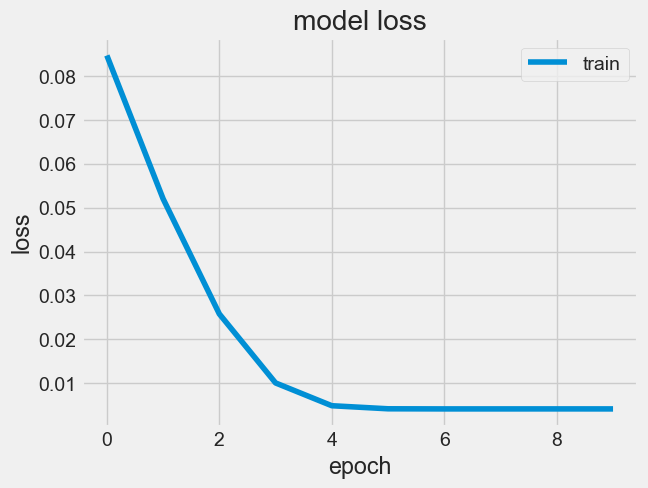

In [15]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(16, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))


# Compile the model
optimizer = Adam(lr=1e-5)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(x_train, y_train, batch_size=5, epochs=10)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [16]:
Ytest_data = y_scaled_data[training_data_len : , :]
Xtest_data = y_scaled_data[training_data_len : , :]
# Create the data sets x_test and y_test
x_test = []

y_test = dataset[["nextWeekChg"]][training_data_len:-window]
for i in range(window, len(Xtest_data)):
    x_test.append(Xtest_data[i-window:i, 0])
# Convert the data to a numpy array
x_test = np.array(x_test)
x_test.shape, y_test.shape

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse



25/25 [==============================] - 1s 3ms/step


0.03214374475551929

C:\Users\bruce\AppData\Local\Temp\ipykernel_7700\194574295.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["predictChg"] = predictions
C:\Users\bruce\AppData\Local\Temp\ipykernel_7700\194574295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid["PredClose"]  = valid["Close"] *valid["predictChg"]


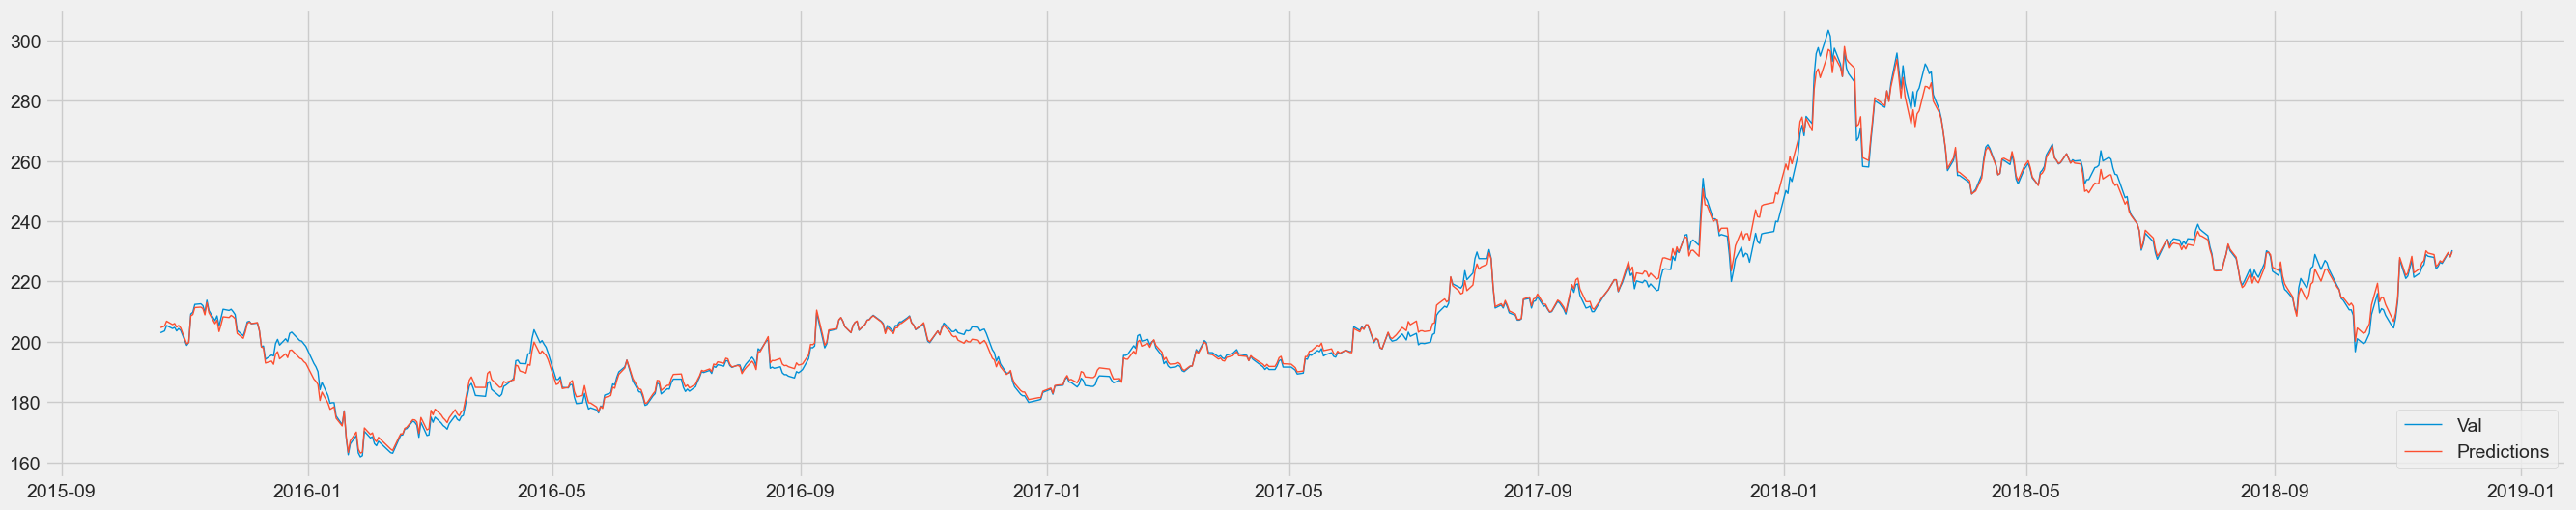

In [17]:
valid = dataset[training_data_len:-window]
valid["predictChg"] = predictions
valid
valid["PredClose"]  = valid["Close"] *valid["predictChg"]
plt.figure(figsize=(30,6))
plt.plot(valid[['Close', 'PredClose']],linewidth=1)
plt.legend([ 'Val', 'Predictions'], loc='lower right')
plt.show()


In [18]:

df

NameError: name 'df' is not defined

In [ ]:
df =valid.resample('W').mean()
df["predictlabel"]= (df['predictChg'] > 1.0).astype(int)
df["label"]= (df['nextWeekChg'] > 1.0).astype(int)
df["temp"]= (df['predictlabel'] == df['label'] ).astype(int)
df.to_csv("temp.csv")
count = valid["temp"].sum()

In [ ]:
count = df["temp"].sum()
count